In [2]:
# !pip install yfinance antropy --quiet

import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, yfinance as yf, time
import matplotlib.pyplot as plt
from antropy import perm_entropy
from scipy.stats import pearsonr

np.random.seed(42)


In [3]:
import os

if os.path.exists("project5_World_Stock_data.csv"):
    adj_close = pd.read_csv("project5_World_Stock_data.csv", index_col=0, parse_dates=True)
    print("Loaded data from CSV.")
else:

    tickers = [
        # DM
        'MSFT','GOOGL','JPM','AAPL','AMZN','TSLA','JNJ','V','PG','MA','HD','NVDA','COST','NFLX','PEP','ADBE','PYPL','CRM','T','INTC',
        'CSCO','SBUX','KO','DIS','BP','TM','GME','RBLX','ZM','GM','F','AMD','LMT','BA','CAT','FDX','MMM','WMT','ETSY','ROKU','PINS',
        'SPOT','COIN','PLTR','SNOW','MRO','AAL','SAVE','KR','WBA','KSS','XOM','RIVN','RY.TO','TD.TO','ENB.TO','CNR.TO','BCE.TO','SHOP.TO',
        'TRP.TO','AEM.TO','BMO.TO','MFC.TO','VOD.L','SHEL.L','RR.L','HSBA.L','RIO.L','ULVR.L','GSK.L','BP.L','NG.L','BARC.L','LLOY.L',
        'AHT.L','AZN.L','DGE.L','SMIN.L','MC.PA','SAN.PA','AIR.PA','RMS.PA','BNP.PA','GLE.PA','ORA.PA','SGO.PA','PUB.PA','TTE.PA',
        'VOW3.DE','SAP.DE','SIE.DE','BAYN.DE','BAS.DE','SONY','HMC','7203.T','9984.T','8031.T','9433.T','4502.T','4519.T','6752.T','4901.T',
        'BHP.AX','RIO.AX','CBA.AX','WES.AX','ANZ.AX','NAB.AX','TLS.AX','MQG.AX','WDS.AX','ASX.AX',
        # EM
        '9988.HK','JD','BIDU','XPEV','NIO','BABA','1810.HK','3690.HK','2601.HK','6098.HK','2018.HK','3988.HK','1398.HK',
        'RELIANCE.NS','HDFCBANK.NS','INFY.NS','TCS.NS','KOTAKBANK.NS','WIPRO.NS','SBIN.NS','BHARTIARTL.NS','AXISBANK.NS','ICICIBANK.NS',
        'TITAN.NS','ASIANPAINT.NS','MARUTI.NS','LT.NS','HINDUNILVR.NS','2330.TW','2454.TW','2303.TW','2881.TW','1301.TW',
        '005930.KS','066570.KS','000660.KS','035420.KS','005380.KS',
        'BBCA.JK','BBRI.JK','TLKM.JK','ASII.JK','BMRI.JK','PTT.BK','CPALL.BK','ADVANC.BK','KBANK.BK','SCB.BK',
        'VALE3.SA','PETR4.SA','ITUB4.SA','BBDC4.SA','ABEV3.SA','LREN3.SA','CIEL3.SA','CVCB3.SA','AZUL4.SA','BPAC11.SA',
        'AMXL.MX','CEMEXCPO.MX','WALMEX.MX','FEMSAUB.MX','GFNORTEO.MX',
        'ENELCHIL.SN','FALAB.SN','SQM.SN','CCU.SN','COPEC.SN',
        'PFAVAL.CO','GRUPOSURA.CO','CEMARGOS.CO','ECOPETROL.CL','CLH.CO','PFBANC.CL',
        'BHP.JO','ANH.JO','NPN.JO','FSR.JO','SBK.JO',
        '2222.SR','7010.SR','1010.SR','2010.SR','6001.SR','TUPRS.IS','GARAN.IS','THYAO.IS','ISCTR.IS','SAHOL.IS',
        'OPAP.AT','OTE.AT','EUROB.AT','TPEIR.AT','ETE.AT',
        # TF / Frontier (some may fail; that’s fine)
        'VIC.HM','VHM.HM','HPG.HM','VRE.HM','VNM.HM','TCB.HM','CTG.HM','STB.HM','FPT.HM','MBB.HM',
        'LUCK.PS','HBL.PS','FFC.PS','OGDC.PS','ENGRO.PS','PPL.PS','MCB.PS','BAHL.PS','TRG.PS','PAEL.PS',
        'TEL.PS','SM.PS','BDO.PS','AC.PS','JGS.PS','GLO.PS','MER.PS','SECB.PS','DMC.PS','URC.PS',
        'MAYBANK.KL','TENAGA.KL','PCHEM.KL','CIMB.KL','HLBANK.KL','DIGI.KL','IHH.KL','MAXIS.KL','TM.KL','MISC.KL',
        'PKN.WA','PEO.WA','PZU.WA','KGH.WA','CCC.WA',
        'CEZ.PR','KOMB.PR','ERSTE.PR','VIG.PR','MONET.PR',
        'OTP.BD','MOL.BD','RICHTER.BD','MTELEKOM.BD','OPUS.BD',
        'FP.RO','TLV.RO','SNP.RO','BRD.RO','SNG.RO',
        'KCEL.KZ','HSBK.KZ','KZTO.KZ','CCBN.KZ','KMG.KZ',
        'COMI.CA','HRHO.CA','TMGH.CA','EKHO.CA','QNAA.CA',
        'BCP.CS','ATW.CS','IAM.CS','RMA.CS','LNA.CS',
        'DANGCEM.LG','NESTLE.LG','GUARANTY.LG','MTNN.LG','ZENITHBANK.LG',
        'SAFCOM.NR','EQBNK.NR','KPLC.NR','BBK.NR','BAMB.NR',
        'YPFD.BA','BMA.BA','GGAL.BA','CEPU.BA','CRES.BA'
    ]
    start_date, end_date = "2020-01-01", "2025-01-01"
    print(len(tickers), "tickers to be tested.")

    # --- Step 3: Download (simple + robust) ---

    adj_series, close_series, vol_series = [], [], []
    fails = []

    for tk in tickers:
        try:
            df = yf.download(tk, start=start_date, end=end_date, progress=False, auto_adjust=False)
            if df is None or df.empty:
                fails.append(tk); continue

            # Ensure needed columns exist and are Series with DatetimeIndex
            if not all(c in df.columns for c in ["Adj Close", "Close", "Volume"]):
                fails.append(tk); continue

            s_adj  = df["Adj Close"].dropna()
            s_close= df["Close"].dropna()
            s_vol  = df["Volume"].replace(0, np.nan).dropna()

            # sanity checks
            if s_adj.empty or s_close.empty or s_vol.empty:
                fails.append(tk); continue

            # name the series so concat makes proper columns
            s_adj.name   = tk
            s_close.name = tk
            s_vol.name   = tk

            adj_series.append(s_adj)
            close_series.append(s_close)
            vol_series.append(s_vol)

        except Exception:
            fails.append(tk)
        time.sleep(0.1)  # be gentle on Yahoo

    print("OK:", len(adj_series), "| Failed:", len(fails))

    # Build wide DataFrames (align on dates)
    adj_close = pd.concat(adj_series, axis=1).sort_index()
    close     = pd.concat(close_series, axis=1).reindex_like(adj_close)
    volume    = pd.concat(vol_series, axis=1).reindex_like(adj_close)

    # Save downloaded and cleaned data
    adj_close.to_csv("project5_World_Stock_data.csv")

    # Drop columns that are all-NaN after alignment
    keep = adj_close.columns[adj_close.notna().sum() > 0]
    adj_close, close, volume = adj_close[keep], close[keep], volume[keep]

print(adj_close.shape, close.shape, volume.shape)


297 tickers tested.



1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SAVE']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['7203.T']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')

1 Failed download:
['CIEL3.SA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AMXL.MX']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['ENELCHIL.SN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['FALAB.SN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SQM.SN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PFAVAL.CO']: YFTzMissingError('possibly delisted; no timezone found')


OK: 220 | Failed: 77
(1560, 220) (1560, 220) (1560, 220)


In [4]:
# Log returns
ret = np.log(adj_close / adj_close.shift(1))

# Dollar volume
dollar_vol = close * volume

# Align & clean
ret = ret.dropna(how="all")
dollar_vol = dollar_vol.reindex(ret.index)

# Daily Amihud: |r| / dollar_volume ; average × 1e6
ami = (ret.abs() / dollar_vol.replace(0, np.nan)).mean(axis=0) * 1_000_000
ami = ami.replace([np.inf, -np.inf], np.nan).dropna()


In [5]:
M_VALUES = [3,5,6]
pe = {m: {} for m in M_VALUES}

for tk in ret.columns:
    x = ret[tk].dropna().values
    if len(x) < 260:  # need enough samples
        continue
    for m in M_VALUES:
        try:
            pe[m][tk] = perm_entropy(x, order=m, delay=1, normalize=True)
        except Exception:
            pe[m][tk] = np.nan

pe_df = pd.DataFrame({f"PE_m{m}": pd.Series(pe[m]) for m in M_VALUES})


In [13]:
panel_std = np.nanmean(ret.std().values)
series_len = len(ret.index)
bench = np.random.normal(0.0, panel_std, series_len)
pe_bench_m3 = perm_entropy(bench, order=3, delay=1, normalize=True)
pe_bench_m5 = perm_entropy(bench, order=5, delay=1, normalize=True)
pe_bench_m6 = perm_entropy(bench, order=6, delay=1, normalize=True)

results = pd.concat([ami.rename("Avg_Amihud_x1M"), pe_df], axis=1).dropna()
results = results.sort_values("Avg_Amihud_x1M")
print("Rows:", len(results))
print("Numerical Benchmark PE (m=3):", round(pe_bench_m3,4))
print("Numerical Benchmark PE (m=5):", round(pe_bench_m5,4))  
print("Numerical Benchmark PE (m=6):", round(pe_bench_m6,4))
results.head(10)


Rows: 220
Numerical Benchmark PE (m=3): 0.9997
Numerical Benchmark PE (m=5): 0.9918
Numerical Benchmark PE (m=6): 0.955


,Avg_Amihud_x1M,PE_m3,PE_m5,PE_m6
BBCA.JK,1.698156e-08,0.998633,0.988048,0.935666
BBRI.JK,1.934916e-08,0.998293,0.985123,0.932739
TLKM.JK,3.341698e-08,0.998691,0.984880,0.927694
BMRI.JK,3.617327e-08,0.998913,0.982705,0.933235
ASII.JK,5.510347e-08,0.993849,0.978232,0.918946
NPN.JO,8.877505e-08,0.999324,0.989196,0.933505
005930.KS,9.119113e-08,0.999077,0.985141,0.932524
9984.T,1.923533e-07,0.998188,0.986666,0.925736
FSR.JO,1.947464e-07,0.999154,0.987697,0.936122
SBK.JO,2.663561e-07,0.997707,0.987227,0.934864


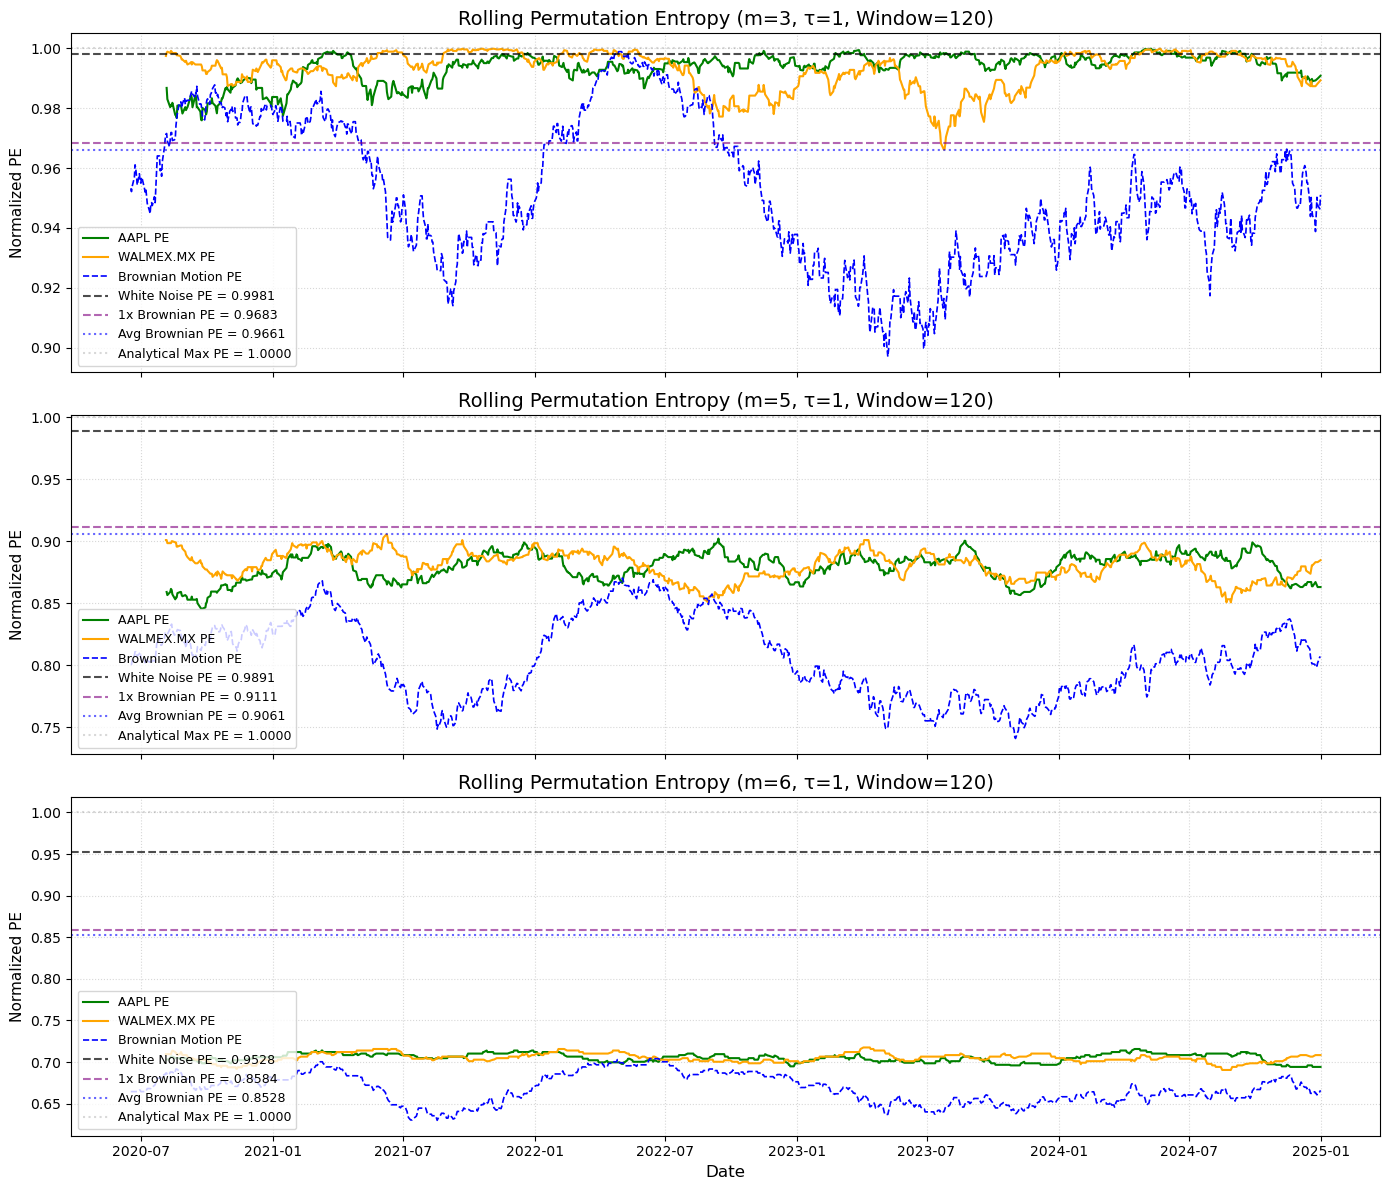

In [12]:
from math import factorial, log2
from antropy import perm_entropy
import matplotlib.pyplot as plt
import numpy as np

# Settings
tau = 1
window_size = 120
m_values = [3, 5, 6]
series_len = len(ret)
std_est = ret.std().mean()

def compute_rolling_pe(series, m, tau, window):
    return series.rolling(window).apply(
        lambda x: perm_entropy(x.values, order=m, delay=tau, normalize=True)
        if x.notna().all() else np.nan,
        raw=False
    )

# Benchmarks
benchmarks = {
    'white_noise': {},
    'brownian_1': {},
    'brownian_mean': {},
    'analytical': {m: 1.0 for m in m_values}
}

# Generate one Brownian motion path
bm_path = np.cumsum(np.random.normal(0, std_est, series_len))
bm_series = pd.Series(bm_path, index=ret.index)

# For plotting: store rolling PE of Brownian motion per m
rolling_pe_bm = {}

for m in m_values:
    # 1. White noise benchmark
    wn = np.random.normal(0, std_est, series_len)
    benchmarks['white_noise'][m] = perm_entropy(wn, order=m, delay=tau, normalize=True)

    # 2. One Brownian motion PE (entire series)
    benchmarks['brownian_1'][m] = perm_entropy(bm_path, order=m, delay=tau, normalize=True)

    # 3. Monte Carlo Brownian average
    bm_many = np.array([
        np.cumsum(np.random.normal(0, std_est, series_len))
        for _ in range(10000)
    ])
    pe_vals = [perm_entropy(path, order=m, delay=tau, normalize=True) for path in bm_many]
    benchmarks['brownian_mean'][m] = np.mean(pe_vals)

    # 4. Rolling PE of the single Brownian motion
    rolling_pe_bm[m] = compute_rolling_pe(bm_series, m, tau, window_size)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for i, m in enumerate(m_values):
    rolling_pe_aapl = compute_rolling_pe(ret["AAPL"].dropna(), m, tau, window_size)
    rolling_pe_walmex = compute_rolling_pe(ret["WALMEX.MX"].dropna(), m, tau, window_size)

    ax = axes[i]
    ax.plot(rolling_pe_aapl.index, rolling_pe_aapl, label="AAPL PE", color="green", linewidth=1.5)
    ax.plot(rolling_pe_walmex.index, rolling_pe_walmex, label="WALMEX.MX PE", color="orange", linewidth=1.5)
    ax.plot(rolling_pe_bm[m].index, rolling_pe_bm[m], label="Brownian Motion PE", color="blue", linestyle="--", linewidth=1.2)

    # Horizontal benchmark lines
    ax.axhline(benchmarks['white_noise'][m], color='black', linestyle='--', alpha=0.7,
               label=f"White Noise PE = {benchmarks['white_noise'][m]:.4f}")
    ax.axhline(benchmarks['brownian_1'][m], color='purple', linestyle='--', alpha=0.6,
               label=f"1x Brownian PE = {benchmarks['brownian_1'][m]:.4f}")
    ax.axhline(benchmarks['brownian_mean'][m], color='blue', linestyle=':', alpha=0.6,
               label=f"Avg Brownian PE = {benchmarks['brownian_mean'][m]:.4f}")
    ax.axhline(1.0, color='gray', linestyle=':', alpha=0.3, label="Analytical Max PE = 1.0000")

    ax.set_title(f"Rolling Permutation Entropy (m={m}, τ={tau}, Window={window_size})", fontsize=14)
    ax.set_ylabel("Normalized PE", fontsize=11)
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend(loc="lower left", fontsize=9)

axes[-1].set_xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()


|           |   Avg_Amihud_x1M |    PE_m3 |    PE_m5 |    PE_m6 |
|:----------|-----------------:|---------:|---------:|---------:|
| BBCA.JK   |         0.000000 | 0.998633 | 0.988048 | 0.935666 |
| BBRI.JK   |         0.000000 | 0.998293 | 0.985123 | 0.932739 |
| TLKM.JK   |         0.000000 | 0.998691 | 0.984880 | 0.927694 |
| BMRI.JK   |         0.000000 | 0.998913 | 0.982705 | 0.933235 |
| ASII.JK   |         0.000000 | 0.993849 | 0.978232 | 0.918946 |
| NPN.JO    |         0.000000 | 0.999324 | 0.989196 | 0.933505 |
| 005930.KS |         0.000000 | 0.999077 | 0.985141 | 0.932524 |
| 9984.T    |         0.000000 | 0.998188 | 0.986666 | 0.925736 |
| FSR.JO    |         0.000000 | 0.999154 | 0.987697 | 0.936122 |
| SBK.JO    |         0.000000 | 0.997707 | 0.987227 | 0.934864 |


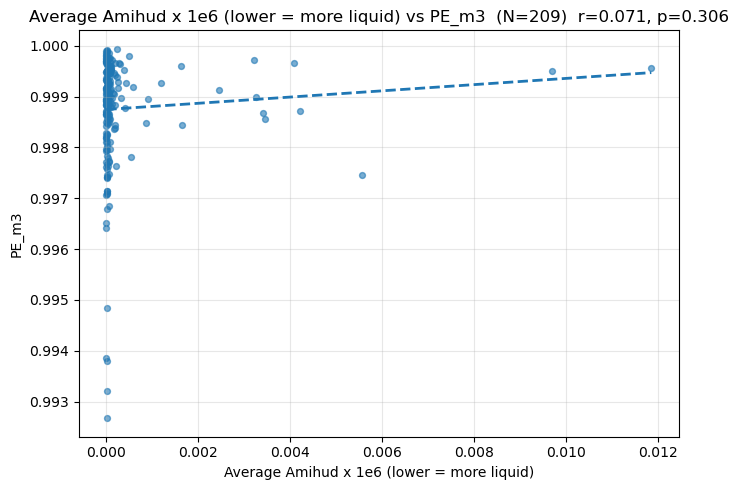

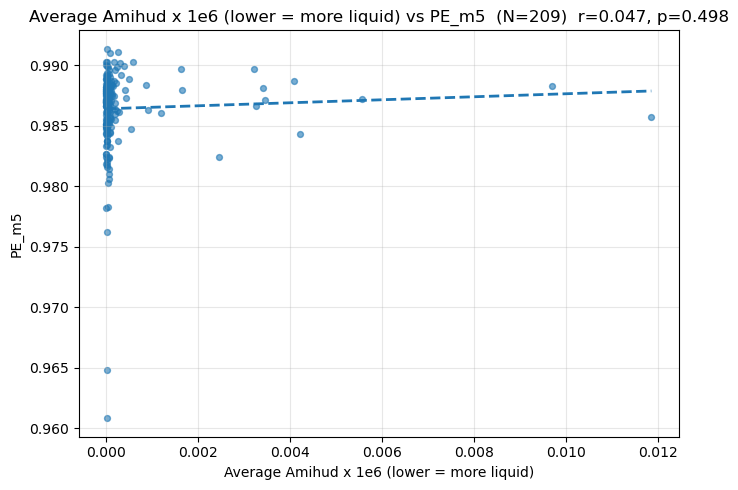

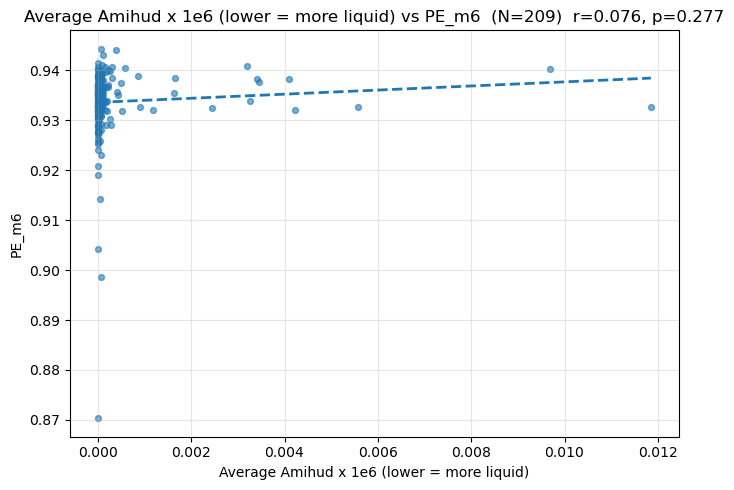

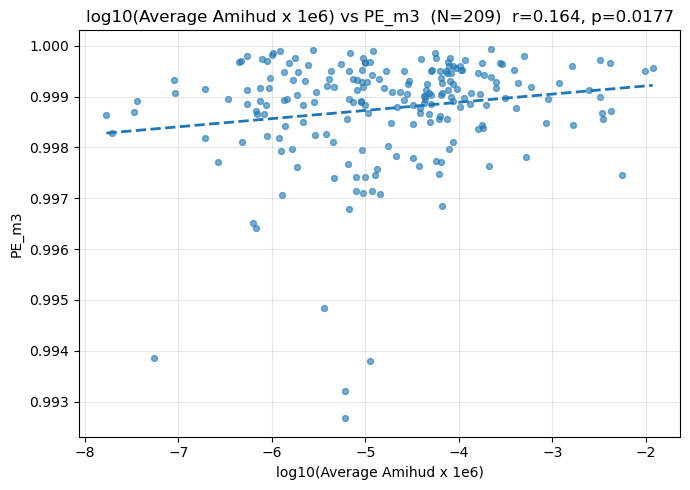

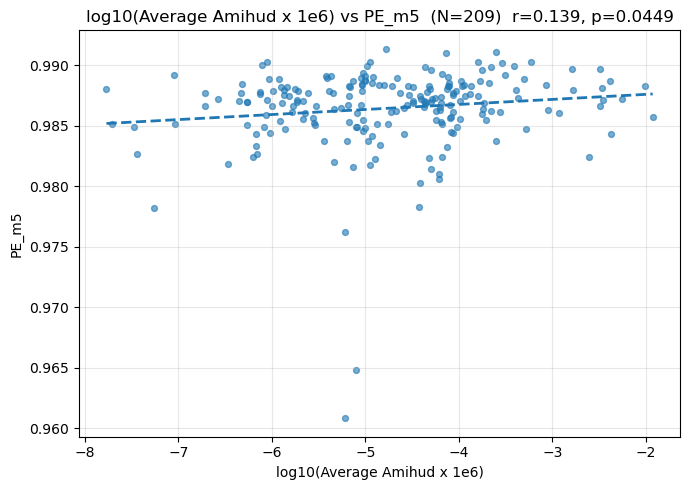

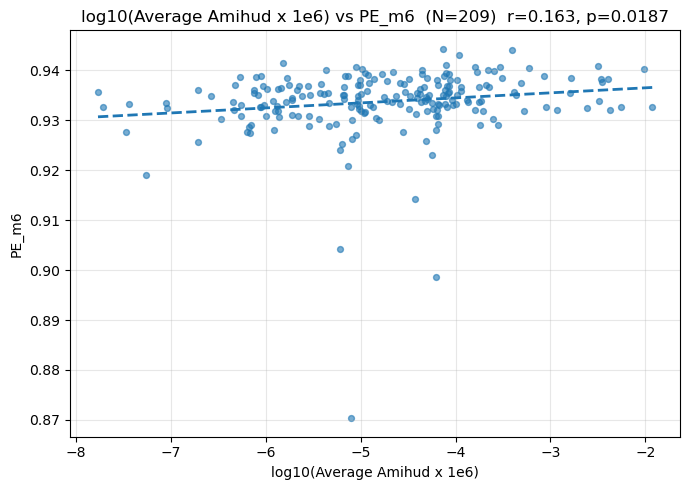

In [8]:
# --- Scatter + regression for PE vs Amihud (linear + log10) ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import pearsonr

if 'results_df' not in globals():
    if 'results' not in globals():
        raise NameError("Neither `results_df` nor `results` exists. Build the results table first.")
    results_df = results.copy()

# sanity: needed columns
need = {"Avg_Amihud_x1M","PE_m3","PE_m5","PE_m6"}
missing = need - set(results_df.columns)
if missing:
    raise ValueError(f"`results_df` is missing columns: {missing}")

# show head (sorted by Amihud) 
print(results_df.sort_values("Avg_Amihud_x1M").head(10).to_markdown(floatfmt=".6f"))

# filter top 5% Amihud outliers for cleaner plots
q95 = results_df["Avg_Amihud_x1M"].quantile(0.95)
df_lin = results_df[results_df["Avg_Amihud_x1M"] < q95].copy()

# add log10 Amihud
df_log = df_lin.copy()
df_log["Log10_Amihud"] = np.log10(df_log["Avg_Amihud_x1M"])

def scatter_with_fit(df, xcol, ycol, xlabel):
    d = df[[xcol, ycol]].replace([np.inf, -np.inf], np.nan).dropna()
    if len(d) < 5:
        print(f"Not enough data to plot {ycol} vs {xcol}"); 
        return
    x, y = d[xcol].values, d[ycol].values
    r, p = pearsonr(x, y)
    z = np.polyfit(x, y, 1)
    xp = np.linspace(x.min(), x.max(), 200)
    yp = np.poly1d(z)(xp)

    plt.figure(figsize=(7,5))
    plt.scatter(x, y, s=18, alpha=0.6)
    plt.plot(xp, yp, linestyle="--", linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ycol)
    plt.title(f"{xlabel} vs {ycol}  (N={len(d)})  r={r:.3f}, p={p:.3g}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Linear scale: Amihud vs PE_m*
for m in (3,5,6):
    scatter_with_fit(df_lin, "Avg_Amihud_x1M", f"PE_m{m}",
                     "Average Amihud x 1e6 (lower = more liquid)")

# Log10 scale: log10(Amihud) vs PE_m*
for m in (3,5,6):
    scatter_with_fit(df_log, "Log10_Amihud", f"PE_m{m}",
                     "log10(Average Amihud x 1e6)")
